##**Load and clean data**##

In [1]:
import os
cwd = os.getcwd()

import pandas as pd

# read excel spreadsheet into a dataframe
raw = pd.read_excel(cwd + '/MAYO-01-17VW Client Data Tables and Stats Mouse Feces.xlsx', header=None, sheet_name=1, usecols="B, N:W", skiprows=lambda x: x in [0, 1, 2, 3, 4, 6])
raw.head()

,1,13,14,15,16,17,18,19,20,21,22
0,NaN,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12
1,(12 or 13)-methylmyristate (a15:0 or i15:0),127452336,398733600,194414640,205534192,190075648,368667328,363972864,177412320,261315008,267093568
2,(14 or 15)-methylpalmitate (a17:0 or i17:0),13088862,17803722,16050609,16540071,24838720,21238488,18666004,13516261,15583477,15641594
3,(16 or 17)-methylstearate (a19:0 or i19:0),1849648,1881931,1832783,2877598,3745333,3074163,2926198,1760097,1750348,2235711
4,(3'-5')-adenylyladenosine*,85744,NaN,30137,NaN,112979,174232,104255,NaN,82381,NaN


In [2]:
def clean(df):
  """
  Processes the raw excel spreadsheet dataframe with pandas. Returns cleaned dataframe
  """
  # tranpose so axis 0 is the example dimension and axis 1 is the features dimension
  transposed = df.transpose()
  transposed.reset_index(drop=True, inplace=True)

  # use first row as header
  # https://stackoverflow.com/a/31328974/14772896
  new_header = transposed.iloc[0] #grab the first row for the header
  transposed = transposed[1:] #take the data less the header row
  transposed.columns = new_header #set the header row as the df header
  transposed.reset_index(drop=True, inplace=True)

  # Make a target column based on whether or not the sample was taken in Week 12
  transposed.insert(0, 'AfterProbiotic', transposed.iloc[:, 0] == 'Week 12', allow_duplicates=False)
  transposed = transposed.loc[:, transposed.columns.notnull()]
  transposed.index.name = None
  transposed.iloc[:, 0] = transposed.iloc[:, 0].astype(int)
  return transposed.apply(pd.to_numeric)

In [3]:
cleaned = clean(raw)
cleaned.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0,127452336,13088862,1849648,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,98221.0,NaN,34724.0,41824.0,6952495.5,3.710256e+06,420394.0,258903.0000,636876.0000,NaN,1.767055e+06,4049742.5,562854.0000,3507385.0,8301770.00,246810.0,6080374.000,12625956,931280.0,228509.0000,2441671,5683364,19908704,1.587143e+06,2210649.000,782299,376039,886376,29414322,155821552,...,67523752,288447456,4820321.0,11264001,15756378,1884308.00,9.716410e+05,1752790.75,60329608,160565888,252152.9844,25159930.0,82117184,3308909.0,2614138,155351760,1261616.0,432454,258522064,591501,1150378,660328.000,49986860,6565542.00,301052544.0,33665008.0,69467.0000,17629108,3713509,5598799.0,875583488,4538598,7908227,25505568.00,141336.0000,1.937091e+06,105549264,168667.0000,4.616876e+06,61953768.0
1,1,398733600,17803722,1881931,NaN,NaN,NaN,NaN,NaN,24328.0000,NaN,NaN,NaN,NaN,5876772.0,8.167889e+05,122128.0,158442.0000,135971.0000,2.029130e+05,4.504270e+05,1356206.0,107786.0000,NaN,6344412.50,317103.0,3717352.750,3576474,NaN,62920.0000,1167618,1899435,4774751,3.219120e+05,1532020.000,544642,165002,791602,41865080,253919760,...,11950671,147919264,1135850.0,8339046,32718874,268750.00,1.022203e+06,11657474.00,40483460,9478781,204753.0000,4254802.0,15167532,1115459.0,4720747,46235656,157247.0,564656,131025232,2543792,498656,997748.000,55208316,3032299.00,NaN,6564965.5,NaN,45081784,3678150,691263.0,390410784,809255,1905679,8003963.00,NaN,4.572610e+05,131103576,23525.0000,1.409255e+06,49363300.0
2,0,194414640,16050609,1832783,30136.9980,NaN,36636.0,45126.0000,NaN,53159.0039,35410.0,NaN,16816.0,27214.0,7356227.0,1.855772e+06,401640.0,129688.9922,217945.0000,NaN,1.160117e+06,1823760.0,430429.9688,1736091.0,4956334.00,122919.0,3057759.000,8649357,104075.0,120197.0000,2380674,4563479,8366090,7.349990e+05,1965338.875,564778,136588,538938,29752018,209019584,...,27731004,195364080,2109509.0,9351121,22206516,1182925.00,6.799360e+05,203

In [14]:
cleaned.isnull().sum().sum()

438

In [15]:
def impute(df):
  """
  Replaces each NAN element in each column with x, where x is the minimum value of sample / 2
  """
  return df.apply(lambda row: row.fillna(row.min() / 2), axis=1)


In [16]:
imputed = impute(cleaned)
imputed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0.0,127452336.0,13088862.0,1849648.0,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,98221.0,0.0,34724.0,41824.0,6952495.5,3.710256e+06,420394.0,258903.0000,636876.0000,0.000000e+00,1.767055e+06,4049742.5,562854.0000,3507385.0,8301770.00,246810.0,6080374.000,12625956.0,931280.0,228509.0000,2441671.0,5683364.0,19908704.0,1.587143e+06,2210649.000,782299.0,376039.0,886376.0,29414322.0,155821552.0,...,67523752.0,288447456.0,4820321.0,11264001.0,15756378.0,1884308.00,9.716410e+05,1752790.75,60329608.0,160565888.0,252152.9844,25159930.0,82117184.0,3308909.0,2614138.0,155351760.0,1261616.0,432454.0,258522064.0,591501.0,1150378.0,660328.000,49986860.0,6565542.00,301052544.0,33665008.0,69467.0000,17629108.0,3713509.0,5598799.0,875583488.0,4538598.0,7908227.0,25505568.00,141336.0000,1.937091e+06,105549264.0,168667.0000,4.616876e+06,61953768.0
1,1.0,398733600.0,17803722.0,1881931.0,0.5000,0.5,0.5,0.5000,0.5,24328.0000,0.5,0.5,0.5,0.5,5876772.0,8.167889e+05,122128.0,158442.0000,135971.0000,2.029130e+05,4.504270e+05,1356206.0,107786.0000,0.5,6344412.50,317103.0,3717352.750,3576474.0,0.5,62920.0000,1167618.0,1899435.0,4774751.0,3.219120e+05,1532020.000,544642.0,165002.0,791602.0,41865080.0,253919760.0,...,11950671.0,147919264.0,1135850.0,8339046.0,32718874.0,268750.00,1.022203e+06,11657474.00,40483460.0,9478781.0,204753.0000,4254802.0,15167532.0,1115459.0,4720747.0,46235656.0,157247.0,564656.0,131025232.0,2543792.0,498656.0,997748.000,55208316.0,3032299.00,0.5,6564965.5,0.5000,45081784.0,3678150.0,691263.0,390410784.0,809255.0,1905679.0,8003963.00,0.5000,4.572610e+05,131103576.0,23525.0000,1.409255e+06,49363300.0
2,0.0,194414640.0,16050609.0,1832783.0,30136.9980,0.0,36636.0,45126.0000,0.0,53159.0039,35410.0,0.0,16816.0,27214.0,7356227.0,1.855772e+06,401640.0,129688.9922,217945.0000,0.000000e+00,1.160117e+06,1823760.0,430429.9688,1736091.0,4956334.00,122919.0,3057759.000,8649357.0,104075.0,120197

In [17]:
imputed.isnull().sum().sum()

0

In [18]:
def scale(df):
  """
  For each column, divides each element by the sum of the elements in the column
  """
  return df.apply(lambda row: row / row.sum(), axis=1)

In [19]:
scaled = pd.concat([imputed.iloc[:, 0], scale(imputed.iloc[:, 1:])], axis=1)
scaled.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0.0,0.003875,0.000398,0.000056,2.607105e-06,1.036591e-06,2.611058e-06,2.968872e-06,9.436709e-07,2.840895e-06,2.986477e-06,0.000000e+00,1.055807e-06,1.271687e-06,0.000211,0.000113,1.278237e-05,0.000008,0.000019,0.000000,0.000054,0.000123,1.711396e-05,1.066445e-04,0.000252,0.000008,0.000185,0.000384,2.831621e-05,6.947973e-06,0.000074,0.000173,0.000605,0.000048,0.000067,0.000024,0.000011,0.000027,0.000894,0.004738,...,0.002053,0.008770,0.000147,0.000342,0.000479,0.000057,0.000030,0.000053,0.001834,0.004882,0.000008,0.000765,0.002497,0.000101,0.000079,0.004724,0.000038,0.000013,0.007861,0.000018,0.000035,0.000020,0.001520,0.000200,9.153710e-03,0.001024,2.112192e-06,0.000536,0.000113,0.000170,0.026623,0.000138,0.000240,0.000776,4.297418e-06,0.000059,0.003209,5.128436e-06,0.000140,0.001884
1,1.0,0.015069,0.000673,0.000071,1.889628e-11,1.889628e-11,1.889628e-11,1.889628e-11,1.889628e-11,9.194176e-07,1.889628e-11,1.889628e-11,1.889628e-11,1.889628e-11,0.000222,0.000031,4.615531e-06,0.000006,0.000005,0.000008,0.000017,0.000051,4.073510e-06,1.889628e-11,0.000240,0.000012,0.000140,0.000135,1.889628e-11,2.377908e-06,0.000044,0.000072,0.000180,0.000012,0.000058,0.000021,0.000006,0.000030,0.001582,0.009596,...,0.000452,0.005590,0.000043,0.000315,0.001237,0.000010,0.000039,0.000441,0.001530,0.000358,0.000008,0.000161,0.000573,0.000042,0.000178,0.001747,0.000006,0.000021,0.004952,0.000096,0.000019,0.000038,0.002086,0.000115,1.889628e-11,0.000248,1.889628e-11,0.001704,0.000139,0.000026,0.014755,0.000031,0.000072,0.000302,1.889628e-11,0.000017,0.004955,8.890702e-07,0.000053,0.001866
2,0.0,0.006844,0.000565,0.000065,1.060940e-06,0.000000e+00,1.289730e-06,1.588612e-06,0.000000e+00,1.871405e-06,1.246570e-06,0.000000e+00,5.919889e-07,9.580392e-07,0.000259,0.000065,1.413930e-05,0.000005,0.000008,0.000000,0.000041,0.000064,1.515282e-05,6.111719e-05,0.000174,0.000004,0.000108,0.000304,3.663847e-06,4.231404e-06,0.00

In [20]:
scaled.describe()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,0.500000,0.008828,0.000586,0.000081,1.981238e-06,1.021141e-06,2.273517e-06,2.810312e-06,4.457219e-07,3.125124e-06,1.751492e-06,6.391675e-07,1.089543e-06,1.395129e-06,0.000313,0.000042,3.593449e-06,3.816031e-06,4.675420e-06,2.267288e-05,0.000019,0.000152,6.520657e-06,2.469729e-05,0.000233,0.000005,0.000133,0.000254,2.385004e-05,2.330066e-06,0.000043,0.000076,0.000202,0.000019,0.000050,0.000022,0.000023,0.000036,0.000981,0.008061,...,0.001743,0.006761,0.000088,0.000342,0.000874,0.000037,0.000060,0.000276,0.001968,0.003252,0.000007,0.000574,0.002204,0.000843,0.000185,0.002514,0.000020,0.000142,0.006080,0.000136,0.000042,0.000033,0.002408,0.000277,0.006332,0.000713,4.065429e-06,0.000872,0.000197,0.000122,0.021223,0.000099,0.000171,0.000692,2.369851e-06,0.000037,0.005485,6.304750e-06,0.000086,0.001968
std,0.527046,0.003867,0.000137,0.000026,2.239708e-06,1.258500e-06,2.564132e-06,2.966545e-06,1.117952e-06,2.747851e-06,2.156389e-06,1.268156e-06,1.178281e-06,1.665302e-06,0.000086,0.000031,5.525887e-06,2.895835e-06,5.865000e-06,4.968558e-05

In [21]:
import numpy as np

def transform(df):
  """ 
  Apply arcsine transformation on all values
  """  
  newdf = df.copy()
  newdf = np.arcsin(np.sqrt(newdf))
  return newdf

In [22]:
transformed = pd.concat([scaled.iloc[:, 0], transform(scaled.iloc[:, 1:])], axis=1)
transformed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0.0,0.062292,0.019951,0.007499,0.001615,0.001018,0.001616,0.001723,0.000971,0.001685,0.001728,0.000000,0.001028,0.001128,0.014540,0.010622,0.003575,0.002806,0.004401,0.000000,0.007330,0.011097,0.004137,0.010327,0.015888,0.002739,0.013597,0.019595,0.005321,0.002636,0.008616,0.013146,0.024606,0.006947,0.008199,0.004877,0.003381,0.005191,0.029910,0.068887,...,0.045327,0.093788,0.012107,0.018508,0.021890,0.007569,0.005435,0.007300,0.042843,0.069929,0.002769,0.027662,0.049989,0.010031,0.008916,0.068783,0.006194,0.003626,0.088776,0.004241,0.005914,0.004481,0.038996,0.014130,0.095822,0.031999,0.001453,0.023154,0.010626,0.013048,0.163897,0.011748,0.015507,0.027852,0.002073,0.007675,0.056681,0.002265,0.011848,0.043416
1,1.0,0.123067,0.025942,0.008434,0.000004,0.000004,0.000004,0.000004,0.000004,0.000959,0.000004,0.000004,0.000004,0.000004,0.014904,0.005556,0.002148,0.002447,0.002267,0.002769,0.004126,0.007159,0.002018,0.000004,0.015485,0.003462,0.011853,0.011626,0.000004,0.001542,0.006643,0.008473,0.013434,0.003488,0.007609,0.004537,0.002497,0.005470,0.039787,0.098118,...,0.021254,0.074838,0.006552,0.017754,0.035172,0.003187,0.006215,0.020991,0.039125,0.018928,0.002782,0.012681,0.023944,0.006493,0.013357,0.041814,0.002438,0.004620,0.070427,0.009805,0.004341,0.006141,0.045694,0.010705,0.000004,0.015752,0.000004,0.041288,0.011790,0.005111,0.121769,0.005530,0.008487,0.017393,0.000004,0.004157,0.070448,0.000943,0.007298,0.043206
2,0.0,0.082824,0.023773,0.008033,0.001030,0.000000,0.001136,0.001260,0.000000,0.001368,0.001116,0.000000,0.000769,0.000979,0.016093,0.008083,0.003760,0.002137,0.002770,0.000000,0.006391,0.008013,0.003893,0.007818,0.013210,0.002080,0.010375,0.017451,0.001914,0.002057,0.009155,0.012675,0.017162,0.005087,0.008318,0.004459,0.002193,0.004356,0.032369,0.085886,...,0.031250,0.083027,0.008618,0.018145,0.027964,0.006453,0.004893,0.008458,0.048088,0.052442,0.002461,0.027618,0.034640,0.007

In [23]:
transformed.describe()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.500000,0.092097,0.024067,0.008908,0.001055,0.000699,0.001130,0.001262,0.000286,0.001505,0.000967,4.205481e-04,0.000784,0.000880,0.017566,0.006137,1.159322e-03,0.001621,0.001685,0.002604,0.004054,0.010508,0.002274,3.065416e-03,0.014640,0.001888,0.011158,0.015621,0.003430,0.001244,0.006397,0.008318,0.013391,0.003922,0.007035,0.004698,0.004049,0.005871,0.030822,0.088661,...,0.039926,0.079548,0.009134,0.018221,0.028025,0.005626,0.007030,0.015600,0.043565,0.053037,0.002659,0.020211,0.044789,0.019162,0.012596,0.049203,0.004170,0.009404,0.077393,0.008897,0.006190,0.005642,0.047891,0.016043,0.057893,0.026191,0.001561,0.028798,0.013264,0.010264,0.143302,0.009510,0.012654,0.025432,0.001358,0.005872,0.071378,0.002377,0.009033,0.038997
std,0.527046,0.020467,0.002828,0.001401,0.000983,0.000769,0.001052,0.001163,0.000636,0.000977,0.000952,7.167112e-04,0.000726,0.000830,0.002323,0.002123,1.580941e-03,0.001149,0.001429,0.004203,0.001725,0.006762,0.001224,4.123258e-03,0.004547,0.001114,0.003052,0.003366,0.003664,0.000932,0.001627,0.002649,0.005069,0.002084,0.001039,0.000637,0.002801,0.001488,0.00591

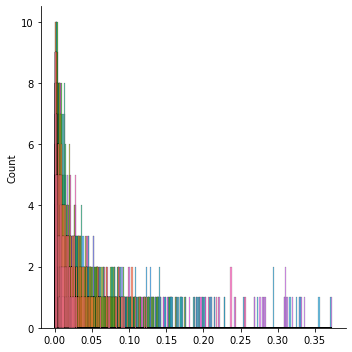

In [24]:
import seaborn as sns
sns.displot(transformed.iloc[:, 1:], legend=False)

In [25]:
transformed['mouseID'] = (np.arange(len(transformed)) // 2) + 1
transformed['isMale'] =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
transformed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose,mouseID,isMale
0,0.0,0.062292,0.019951,0.007499,0.001615,0.001018,0.001616,0.001723,0.000971,0.001685,0.001728,0.000000,0.001028,0.001128,0.014540,0.010622,0.003575,0.002806,0.004401,0.000000,0.007330,0.011097,0.004137,0.010327,0.015888,0.002739,0.013597,0.019595,0.005321,0.002636,0.008616,0.013146,0.024606,0.006947,0.008199,0.004877,0.003381,0.005191,0.029910,0.068887,...,0.012107,0.018508,0.021890,0.007569,0.005435,0.007300,0.042843,0.069929,0.002769,0.027662,0.049989,0.010031,0.008916,0.068783,0.006194,0.003626,0.088776,0.004241,0.005914,0.004481,0.038996,0.014130,0.095822,0.031999,0.001453,0.023154,0.010626,0.013048,0.163897,0.011748,0.015507,0.027852,0.002073,0.007675,0.056681,0.002265,0.011848,0.043416,1,1
1,1.0,0.123067,0.025942,0.008434,0.000004,0.000004,0.000004,0.000004,0.000004,0.000959,0.000004,0.000004,0.000004,0.000004,0.014904,0.005556,0.002148,0.002447,0.002267,0.002769,0.004126,0.007159,0.002018,0.000004,0.015485,0.003462,0.011853,0.011626,0.000004,0.001542,0.006643,0.008473,0.013434,0.003488,0.007609,0.004537,0.002497,0.005470,0.039787,0.098118,...,0.006552,0.017754,0.035172,0.003187,0.006215,0.020991,0.039125,0.018928,0.002782,0.012681,0.023944,0.006493,0.013357,0.041814,0.002438,0.004620,0.070427,0.009805,0.004341,0.006141,0.045694,0.010705,0.000004,0.015752,0.000004,0.041288,0.011790,0.005111,0.121769,0.005530,0.008487,0.017393,0.000004,0.004157,0.070448,0.000943,0.007298,0.043206,1,1
2,0.0,0.082824,0.023773,0.008033,0.001030,0.000000,0.001136,0.001260,0.000000,0.001368,0.001116,0.000000,0.000769,0.000979,0.016093,0.008083,0.003760,0.002137,0.002770,0.000000,0.006391,0.008013,0.003893,0.007818,0.013210,0.002080,0.010375,0.017451,0.001914,0.002057,0.009155,0.012675,0.017162,0.005087,0.008318,0.004459,0.002193,0.004356,0.032369,0.085886,...,0.008618,0.018145,0.027964,0.006453,0.004893,0.008458,0.048088,0.052442,0.002461,0.027618,0.034640,0.007042,0.006775,0.052483,0.003949,0.002250,0.080134,0.

##**Linear Model Setup**##

In [26]:
! mkdir data

In [64]:
# For each biochemical, create a csv file with just that biochemical

for column in range(1, 824):
  df = transformed.iloc[:, [0, column, 824, 825]].copy()
  # change name of the biochem column to abundance
  df['abundance'] = df[df.columns[1]]
  df = df.drop(columns=[df.columns[1]])
  df.to_csv(cwd + "/data/%d.txt" % (column))

In [65]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [66]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [67]:
! mkdir p_values

mkdir: cannot create directory ‘p_values’: File exists


##**Model 1: dependent variable is metabolite; independent variable is time-point.**##



In [84]:
! mkdir p_values/m1

mkdir: cannot create directory ‘p_values/m1’: File exists


In [96]:
%%R
p_vals_m1 = data.frame(
   p_val = c(1:823)
)

In [97]:
%%R

get_p_val_m1 = function(data) {
    model = lm(abundance ~ AfterProbiotic, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val = coef[2]
    return (p_val)
}

In [98]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_val_m1(d)

AfterProbiotic 
     0.2224562 


In [99]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val = tryCatch(
      get_p_val_m1(data),
      error=function(e) {return (1)}
  )
  p_vals_m1[id, 1] = p_val
}

In [100]:
%%R
head(p_vals_m1)

       p_val
1 0.22245618
2 0.52204530
3 0.54159072
4 0.08965573
5 0.17313736
6 0.08809787


In [101]:
%%R
write.csv(p_vals_m1, "p_values/m1/p_vals_time.csv")

##**Model 2: dependent variable is metabolite; independent variables are time-point and mouse sex.**##

In [102]:
! mkdir p_values/m2

In [103]:
%%R

p_vals_m2_time = data.frame(
   p_val = c(1:823)
)
p_vals_m2_sex = data.frame(
   p_val = c(1:823)
)

In [104]:
%%R

get_p_vals_m2 = function(data) {
    model = lm(abundance ~ AfterProbiotic + isMale, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [105]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
plist = get_p_vals_m2(d)
plist

[[1]]
AfterProbiotic 
     0.2558393 

[[2]]
  isMale 
0.998751 



In [106]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m2(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m2_time[id, 1] = p_val_list[1]
  p_vals_m2_sex[id, 1] = p_val_list[2]
}

In [107]:
%%R
head(p_vals_m2_time)

      p_val
1 0.2558393
2 0.4963539
3 0.5381704
4 0.1081239
5 0.2023948
6 0.1070858


In [108]:
%%R

head(p_vals_m2_sex)

      p_val
1 0.9987510
2 0.1827160
3 0.3016666
4 0.6138369
5 0.7915794
6 0.6355328


In [109]:
%%R

write.csv(p_vals_m2_time, "p_values/m2/p_vals_time.csv")
write.csv(p_vals_m2_sex, "p_values/m2/p_vals_sex.csv")

##**Model 3: dependent variable is metabolite; independent variables are time-point and mouse sex, and also control for mouseID as a random-effect (use 'lmer' function with (1|mouseID).**##

In [110]:
! mkdir p_values/m3

In [ ]:
%%R

install.packages("lmerTest")

In [112]:
%%R

p_vals_m3_time = data.frame(
   p_val = c(1:823)
)
p_vals_m3_sex = data.frame(
   p_val = c(1:823)
)

In [ ]:
%%R

library(lmerTest)
get_p_vals_m3 = function(data) {
    model = lmer(abundance ~ AfterProbiotic + isMale + (1|mouseID), data=data)
    coef = coef(summary(model))[,5]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [114]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_vals_m3(d)

R[write to console]: boundary (singular) fit: see ?isSingular



[[1]]
AfterProbiotic 
     0.2558393 

[[2]]
  isMale 
0.998751 



In [ ]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m3(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m3_time[id, 1] = p_val_list[1]
  p_vals_m3_sex[id, 1] = p_val_list[2]
}

In [116]:
%%R 

head(p_vals_m3_time)

       p_val
1 0.25583928
2 0.50329052
3 0.51600729
4 0.09998019
5 0.08269131
6 0.09378884


In [117]:
%%R

head(p_vals_m3_sex)

      p_val
1 0.9987510
2 0.2467495
3 0.3888992
4 0.6791740
5 0.8523852
6 0.7019810


In [118]:
%%R

write.csv(p_vals_m3_time, "p_values/m3/p_vals_time.csv")
write.csv(p_vals_m3_sex, "p_values/m3/p_vals_sex.csv")

##**Analysis**##

In [119]:
biochemicals = list(cleaned.columns[1:])

In [232]:
from statsmodels.stats.multitest import fdrcorrection

def correct(df):
  """
  Returns a dataframe with the pvals corrected for fdr
  """
  num = df.iloc[:, 0].to_numpy()
  corrected = fdrcorrection(num)[1]
  newdf = df.copy()
  newdf.iloc[:, 0] = corrected
  return newdf

In [233]:
def addBiochemicals(df):
  """ Uses global variable 'biochemicals' to replace row indicies with biochemical
  names"""
  copy = df.copy()
  copy.index = biochemicals
  return copy

Model 1

In [234]:
p_vals_m1_time = addBiochemicals(pd.read_csv('p_values/m1/p_vals_time.csv')).iloc[:, [1]]

In [235]:
p_vals_m1_time.nsmallest(5, 'p_val')

,p_val
3-hydroxysuberate,0.000756
valylglycine,0.001037
lithocholate,0.001320
indole-3-carboxylate,0.001695
pheophytin A,0.002079


In [237]:
correct(p_vals_m1_time).nsmallest(5, 'p_val')

,p_val
1-(3-aminopropyl)-2-pyrrolidone,0.197212
10-hydroxystearate,0.197212
1-carboxyethylisoleucine,0.197212
2'-deoxycytidine,0.197212
3b-hydroxy-5-cholenoic acid,0.197212


Model 2

In [238]:
p_vals_m2_time = addBiochemicals(pd.read_csv('p_values/m2/p_vals_time.csv')).iloc[:, [1]]
p_vals_m2_sex = addBiochemicals(pd.read_csv('p_values/m2/p_vals_sex.csv')).iloc[:, [1]]

In [239]:
p_vals_m2_time.nsmallest(5, 'p_val')

,p_val
2-isopropylmalate,0.000164
sarcosine,0.000177
pheophytin A,0.000182
valylglycine,0.000398
lithocholate,0.000664


In [240]:
correct(p_vals_m2_time).nsmallest(5, 'p_val')

,p_val
2-isopropylmalate,0.050037
pheophytin A,0.050037
sarcosine,0.050037
valylglycine,0.081973
lithocholate,0.109272


In [241]:
p_vals_m2_sex.nsmallest(5, 'p_val')

,p_val
equol,0.000089
maltose,0.000208
10-heptadecenoate (17:1n7),0.000276
2-isopropylmalate,0.000570
cysteine,0.000608


In [242]:
correct(p_vals_m2_sex).nsmallest(5, 'p_val')

,p_val
equol,0.072910
10-heptadecenoate (17:1n7),0.075754
maltose,0.075754
2-isopropylmalate,0.093425
4-hydroxybenzoate,0.093425


Model 3

In [243]:
p_vals_m3_time = addBiochemicals(pd.read_csv('p_values/m3/p_vals_time.csv')).iloc[:, [1]]
p_vals_m3_sex = addBiochemicals(pd.read_csv('p_values/m3/p_vals_sex.csv')).iloc[:, [1]]

In [244]:
p_vals_m3_time.nsmallest(5, 'p_val')

,p_val
sarcosine,0.000177
pheophytin A,0.000182
valylglycine,0.000398
succinylcarnitine (C4-DC),0.000517
2-isopropylmalate,0.000530


In [245]:
correct(p_vals_m3_time).nsmallest(5, 'p_val')

,p_val
pheophytin A,0.075056
sarcosine,0.075056
2-isopropylmalate,0.087272
succinylcarnitine (C4-DC),0.087272
valylglycine,0.087272


In [246]:
p_vals_m3_sex.nsmallest(5, 'p_val')

,p_val
equol,0.000089
maltose,0.000208
10-heptadecenoate (17:1n7),0.000276
cysteine,0.000608
methylmalonate (MMA),0.000982


In [247]:
correct(p_vals_m3_sex).nsmallest(5, 'p_val')

,p_val
equol,0.072910
10-heptadecenoate (17:1n7),0.075754
maltose,0.075754
cysteine,0.125159
arabonate/xylonate,0.131128
